In [1]:
!git clone https://github.com/NguyenHien1307/Video-Face-Detection
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd Video-Face-Detection/notebook

Cloning into 'Video-Face-Detection'...
remote: Enumerating objects: 669, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 669 (delta 104), reused 87 (delta 83), pack-reused 537
Receiving objects: 100% (669/669), 133.70 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (344/344), done.
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  

In [2]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [4]:
train_db = 'DFDC'

## **EfficientNetB4**

In [18]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
"""
net_model = 'EfficientNetB4'

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

In [19]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [8]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [9]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

In [10]:
vid_real_faces = face_extractor.process_video('samples/aayfryxljh.mp4')
vid_fake_faces = face_extractor.process_video('samples/yqhouqakbx.mp4')

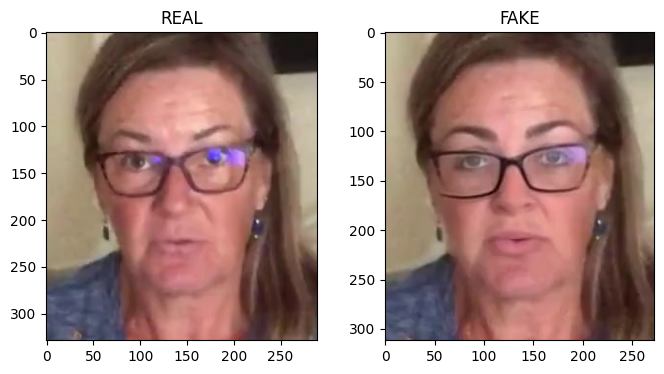

In [11]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(vid_real_faces[0]['faces'][0])
ax[0].set_title('REAL')

ax[1].imshow(vid_fake_faces[0]['faces'][0])
ax[1].set_title('FAKE');

In [20]:
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

<ipython-input-21-c9c20634f4c5>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
<ipython-input-21-c9c20634f4c5>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)


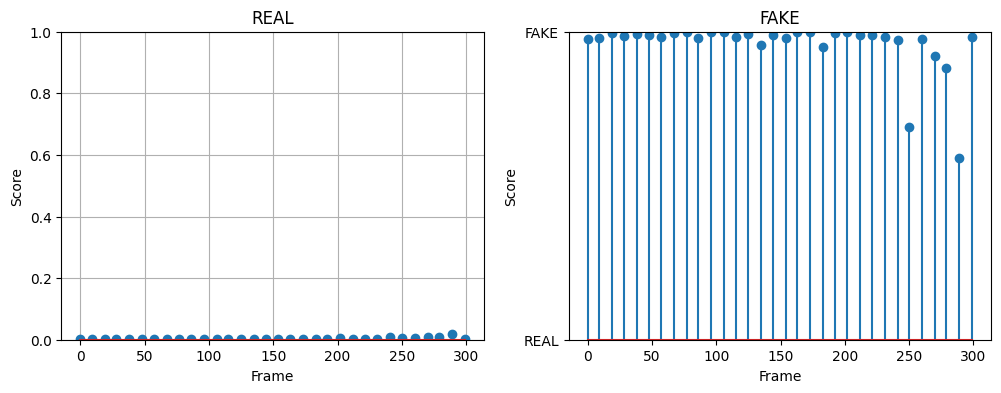

In [21]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

## **EfficientB4ST**

In [22]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
"""
net_model = 'EfficientNetB4ST'

In [23]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4ST_DFDC_bestval-86f0a0701b18694dfb5e7837bd09fa8e48a5146c193227edccf59f1b038181c6.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4ST_DFDC_bestval-86f0a0701b18694dfb5e7837bd09fa8e48a5146c193227edccf59f1b038181c6.pth
100%|██████████| 33.9M/33.9M [00:01<00:00, 28.1MB/s]


<All keys matched successfully>

In [24]:
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

<ipython-input-25-c9c20634f4c5>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
<ipython-input-25-c9c20634f4c5>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)


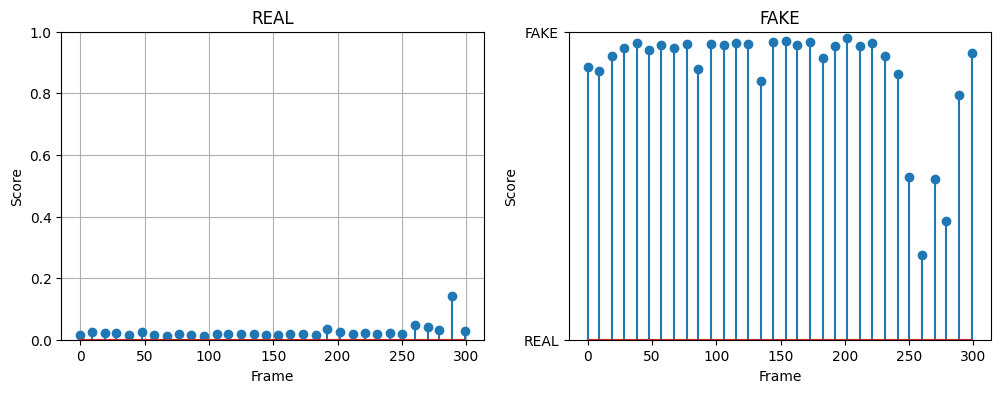

In [25]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

## **EfficientB4Att**

In [26]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
"""
net_model = 'EfficientNetAutoAttB4'

In [27]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [28]:
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

<ipython-input-29-c9c20634f4c5>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
<ipython-input-29-c9c20634f4c5>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)


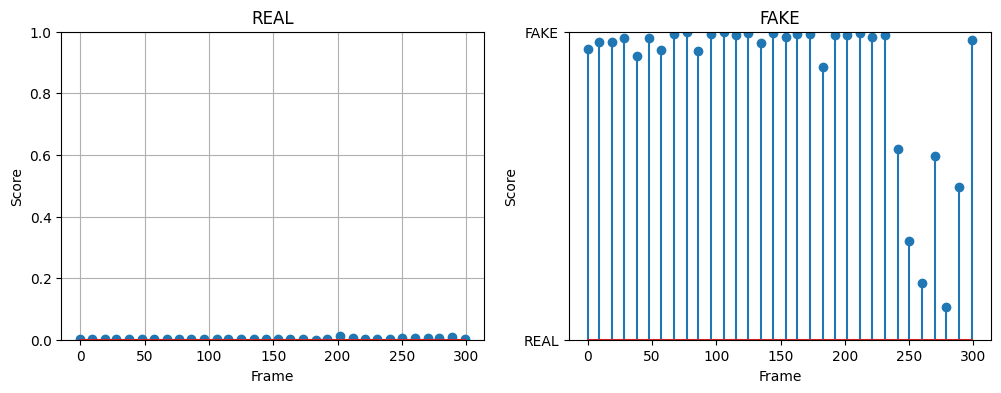

In [29]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

## **EfficientB4AttST**

In [30]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
"""
net_model = 'EfficientNetAutoAttB4ST'

In [31]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4ST_DFDC_bestval-4df0ef7d2f380a5955affa78c35d0942ac1cd65229510353b252737775515a33.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4ST_DFDC_bestval-4df0ef7d2f380a5955affa78c35d0942ac1cd65229510353b252737775515a33.pth
100%|██████████| 33.9M/33.9M [00:01<00:00, 24.9MB/s]


<All keys matched successfully>

In [32]:
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

<ipython-input-33-c9c20634f4c5>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
<ipython-input-33-c9c20634f4c5>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)


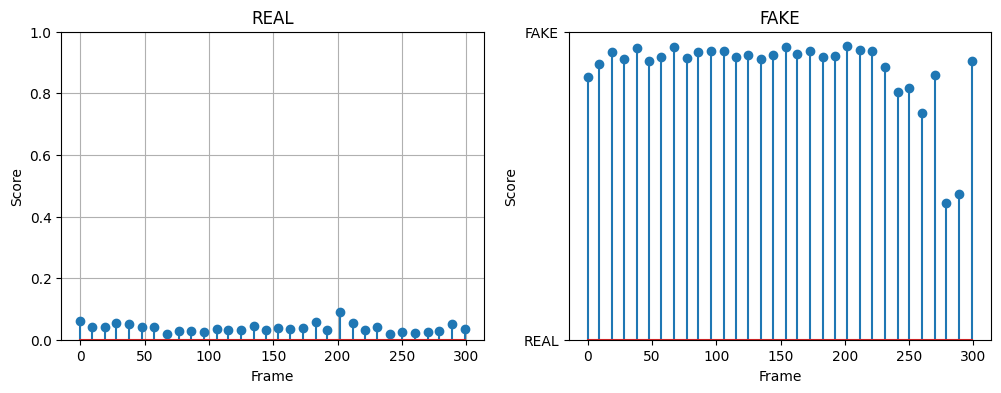

In [33]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);